# Tracking and Detection in Computer Vision Exercise 3

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from scipy import misc
import imageio # because misc.imread is deprecated
import tensorflow as tf
#import cv2
import os
import random

import props

In [2]:
%matplotlib inline
random.seed()

Check that all necessary properties are defined and reasonable

In [3]:
print(props.DATA_ROOT)
print(props.DATA_PREP)
print(props.WEIGHTS)
print(props.LOGS)

dataset/
preprocessing/
model/model.ckpt
log/


# Task 1 Data Preparation

## Utility functions to load the data

In [4]:
def load_and_normalize_image(img_path):
    img = imageio.imread(img_path)
    img_norm = (img - np.mean(img,axis=(0,1)))/np.std(img,axis=(0,1))
    return img_norm

In [5]:
def read_folder(folder_path, class_label, mask=[], direct=False):
    # gets the images in folder folder_path that are also in mask,
    # or if direct=False the images that are not in mask
    directory = os.fsencode(folder_path)
    image_files = []
    quaternions = []
    real_mask = []
    parent_folder = folder_path.split('/')[-3] # here we assume the files are stored in "xxx/abc/xxx/abc123.png
    quaternions = [[float(s) for s in line.split()]\
                     for line in open(folder_path + 'poses.txt').readlines()[1::2]]
    if direct:
        real_mask = mask
    else:
        real_mask = [i for i in range(len(quaternions)) if i not in mask]
    classes = [class_label]*len(real_mask)
    
    for n in real_mask:
        filename = parent_folder + str(n) + ".png"
        image_files.append(load_and_normalize_image(folder_path + filename))
        
    return image_files, [quaternions[i] for i in real_mask], classes

### Testing the above functions

In [6]:
for i in range(1): # just to avoid creating useless global variables
    i1, q1, l1 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0)
    i2, q2, l2 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0, [2,3,5,7,9])
    i3, q3, l3 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0, [2,3,5,7,9], True)
    print (len(i1))
    print (len(i2))
    print (len(i3))
    print (len(q1))
    print (len(q2))
    print (len(q3))
    print (len(l1))
    print (len(l2))
    print (len(l3))
    print (q2[0])
    print (np.shape(i2[0]))
    #print(i2[0][::8,::8,:])

267
262
5
267
262
5
267
262
5
[-0.21679691686430014, -0.5855909685700639, 0.7631570083471646, -0.16635412522060855]
(64, 64, 3)


## Utility functions to visualize images

In [7]:
def to_visible(image):
    # puts image back in [0;1], so that we can visualize it
    mn = np.min(image)
    wd = np.max(image) - mn
    
    return (image - mn)/wd

def concatenate(images, indices):
    if len(np.shape(indices)) == 1:
        # concatenate samples from images with indices in 1D indices into one line
        res = to_visible(images[indices[0]])
        for index in indices[1:]:
            res = np.concatenate((res, to_visible(images[index])), axis=1)
        return res
    else:
        # reduce one dimension
        res = concatenate(images, indices[0])
        for index_array in indices[1:]:
            res = np.concatenate((res, concatenate(images, index_array)), axis=0)
        return res

def visualize(images, indices, save_path=""):
    fig = plt.figure()
    plt.imshow(concatenate(images, indices))
    plt.axis('off')
    if len(save_path) > 0:
        plt.savefig(save_path, pad_inches=0) # TODO there is still some white remaining in the result
    plt.show()

## Load the images and quaternions into datasets

_You need to read the images together with the poses (stored in quaternions) and construct 3 datasets:
the training set $S_{train}$ (train subset of the real folder and fine folder), test set $S_{test}$ (test
subset of the real folder) and database set $S_{db}$ ("coarse" folder)_

In [8]:
class Dataset:
    
    def __init__(self):
        self.images = [] # pictures
        self.quats = [] # poses of each picture
        self.classes = [] # classes of each picture
    """ >> TODO make these work
    def add_image(img, quat, self):
        self.images.append(img)
        self.quats.append(quat)
    
    def get_image(i, self):
        img = self.images[i]
        quat = self.quats[i]
        return img, quat
    
    def add_data(imgs, quats, self):
        for img, quat in imgs, quats:
            self.add_image(img, quat)
    """

In [9]:

CLASSES = ['ape', 'benchvise', 'cam', 'cat', 'duck']

print("[WARNING] Remove real/duck/real1178-1252, we don't have their poses!")

S_TRAIN = Dataset()

S_TEST = Dataset()

S_DB = Dataset()

TRAIN_MASK = [int(s) for s in open(props.DATA_ROOT + 'real/training_split.txt')\
               .readlines()[0].split(',')]


[WARNING] Remove real/duck/real1178-1252, we don't have their poses!


In [10]:
for class_index in range(len(CLASSES)):
    class_name = CLASSES[class_index]
    print(class_name)
    img_db, quat_db, c_db = read_folder(props.DATA_ROOT + 'coarse/' + class_name + '/', class_index)
    img_fn, quat_fn, c_fn = read_folder(props.DATA_ROOT + 'fine/' + class_name + '/', class_index)
    img_tn, quat_tn, c_tn = read_folder(props.DATA_ROOT + 'real/' + class_name + '/', class_index,
                                 TRAIN_MASK, True)
    img_ts, quat_ts, c_ts = read_folder(props.DATA_ROOT + 'real/' + class_name + '/', class_index,
                                 TRAIN_MASK, False)
    
    
    for img in img_db:
        S_DB.images.append(img)
    for quat in quat_db:
        S_DB.quats.append(quat)
    for c in c_db:
        S_DB.classes.append(c)
    for img in img_fn:
        S_TRAIN.images.append(img)
    for quat in quat_fn:
        S_TRAIN.quats.append(quat)
    for c in c_fn:
        S_TRAIN.classes.append(c)
    for img in img_tn:
        S_TRAIN.images.append(img)
    for quat in quat_tn:
        S_TRAIN.quats.append(quat)
    for c in c_tn:
        S_TRAIN.classes.append(c)
    for img in img_ts:
        S_TEST.images.append(img)
    for quat in quat_ts:
        S_TEST.quats.append(quat)
    for c in c_ts:
        S_TEST.classes.append(c)
    
    

ape
benchvise
cam
cat
duck


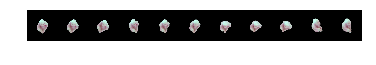

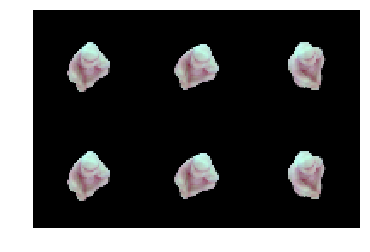

In [11]:
visualize(S_DB.images, [0, 1,2,3, 4, 5, 6, 7, 8, 9, 10])
visualize(S_DB.images, [[1,2,3],[1,2,3]], props.DATA_PREP + "test.png")

### Check datasets

Sizes should be 2-by-2 equal, images contain $64 \times 64 \times 3$ arrays, quaternions contain 4 coordinates, classes just one, and sizes be 1335 for DB, 7410 for TRAIN and 3535 for TEST

In [12]:
print (np.shape(S_DB.images))
print (np.shape(S_DB.quats))
print (np.shape(S_DB.classes))
print (np.shape(S_TRAIN.images))
print (np.shape(S_TRAIN.quats))
print (np.shape(S_TRAIN.classes))
print (np.shape(S_TEST.images))
print (np.shape(S_TEST.quats))
print (np.shape(S_TEST.classes))

(1335, 64, 64, 3)
(1335, 4)
(1335,)
(7410, 64, 64, 3)
(7410, 4)
(7410,)
(3535, 64, 64, 3)
(3535, 4)
(3535,)


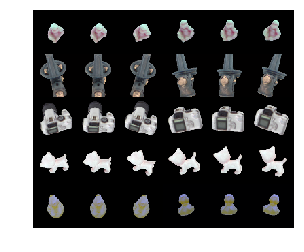

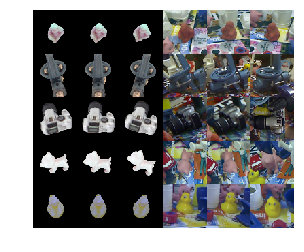

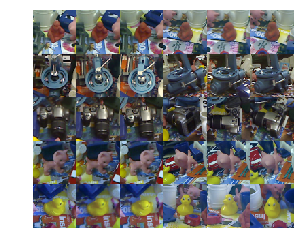

In [13]:
for h in range(1):
    n = len(S_DB.images) // 5
    visualize(S_DB.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])
    n = len(S_TRAIN.images) // 5
    visualize(S_TRAIN.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])
    n = len(S_TEST.images) // 5
    visualize(S_TEST.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])

## Batch generator

_The batch generator should be able to construct batches of triplets that are
later fed to the network. Each triplet consists of 3 samples: anchor, puller, and
pusher. Anchor is chosen randomly from the training set $S_{train}$. Puller is the most similar
(quaternion-wise) to anchor sample of the same object taken from the db set $S_{db}$. Finally, there are 2 types of pushers: it can either be the same object but a different
from puller pose or a randomly chosen different object. Pushers are also drawn from $S_{db}$_

### Create a random batch element following these requirements

Since quaterions in our case are of unit norm, their dot product is always in [0;1] in absolute value. Since arccos is strictly non-decreasing over [0;1], minimizing the quaternion angular metric $\theta(q_1, q_2) = 2 arccos(|q_1.q_2|)$ is strictly equivalent to maximizing their dot product, which is what we do to find the puller, for obvious speed reasons

In [14]:
def find_puller(quat, c):
    best_puller = 0
    best_result = 0
    # only look for a puller of the same class!
    for index in range(len(S_DB.quats) // 5):
        current_result = abs(np.dot(quat, S_DB.quats[index + c*len(S_DB.quats) // 5]))
        if current_result > best_result:
            best_puller = index
            best_result = current_result
    return best_puller + c*len(S_DB.quats) // 5

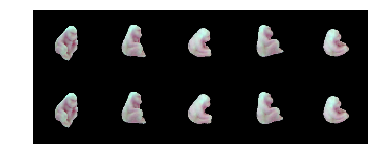

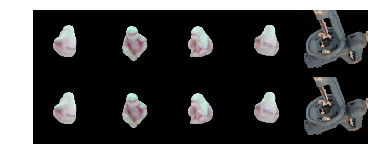

In [15]:
for a in range(1):
    images = []
    for i in range(10):
        k = random.randrange(0,300)
        images.append(S_TRAIN.images[k])
        p = find_puller(S_TRAIN.quats[k], S_TRAIN.classes[k])
        images.append(S_DB.images[p])
    visualize(images, [[2*k for k in range(5)], [2*k+1 for k in range(5)]])
    
    images = []
    for i in range(5):
        k = random.randrange(0,300)
        images.append(S_DB.images[k])
        p = find_puller(S_DB.quats[k], S_DB.classes[k])
        images.append(S_DB.images[p])
    visualize(images, [[2*k for k in range(5)], [2*k+1 for k in range(5)]])

In [16]:
def find_pusher(index, change_pose=0.5):
    nb_poses_per_object = len(S_DB.quats) // 5
    if (random.random() > change_pose):
        # then find another image with the same pose:
        # since all objects have the poses in the same order, this implies
        # looking for (index + R * N_DB / 5) % N_DB, where R is randomly
        # chosen in [1;4]
        R = random.randrange(1,5)
        return (index + R * nb_poses_per_object) % len(S_DB.quats)
    else:
        # then find another pose for the same image:
        # looking for a random number in index's interval [A,A+1]*N_DB/5
        # that isn't index, so basically (index + R) % N_DB/5 + A*N_DB/5
        # where R is randomly drawn in [1;N_DB/5]
        R = random.randrange(1,nb_poses_per_object)
        A = index // nb_poses_per_object
        return (index + R) % nb_poses_per_object + A * nb_poses_per_object

In [17]:
print("Number of poses per object:\t"+str(len(S_DB.quats) // 5))
print("Same pose, all objects are:", end='\t', flush=True)
for i in range(5):
    print(i * (len(S_DB.quats) // 5) + 325 % (len(S_DB.quats) // 5), end='\t', flush=True)
print("\nSame object, different poses are in:", end='\t', flush=True)
for i in range(1):
    N = len(S_DB.quats) // 5
    print(str((325 // N)*N) + "\t" + str((1 + 325 // N)*(N)) + "\nPusher examples:", end='\t', flush=True)
for i in range(100):
    print(find_pusher(325), end='\t', flush=True)

Number of poses per object:	267
Same pose, all objects are:	58	325	592	859	1126	
Same object, different poses are in:	267	534
Pusher examples:	592	446	357	859	346	443	358	859	592	323	521	289	463	343	1126	395	1126	1126	859	504	58	1126	58	592	379	859	859	281	408	592	58	517	592	592	342	349	460	423	859	321	392	310	592	1126	407	592	1126	58	477	321	1126	445	859	324	1126	592	1126	355	1126	1126	58	859	859	488	859	58	323	528	436	532	481	859	383	388	58	274	592	58	1126	58	431	336	1126	506	383	859	293	477	305	290	500	511	456	466	58	1126	522	58	301	424	

In [18]:
def find_batch(change_pose=0.5):
    anchor = random.randrange(0, len(S_TRAIN.quats))
    puller = find_puller(S_TRAIN.quats[anchor], S_TRAIN.classes[anchor])
    pusher = find_pusher(puller, change_pose)
    return anchor, puller, pusher

In [19]:
for i in range(20):
    print(find_batch(), end="   ", flush=True)

(3317, 623, 89)   (1849, 373, 347)   (579, 162, 1230)   (1688, 329, 1130)   (1984, 394, 1195)   (967, 259, 1060)   (1440, 190, 253)   (3053, 569, 35)   (541, 130, 397)   (3140, 593, 544)   (113, 44, 311)   (4117, 568, 594)   (2702, 451, 985)   (1627, 316, 517)   (2871, 526, 259)   (6235, 1159, 358)   (4349, 738, 204)   (6639, 1272, 1152)   (2218, 466, 1000)   (1544, 293, 446)   

## Generate the batch proper

In [20]:
def generate_batch(batch_size, change_pose=0.5):
    return [find_batch(change_pose) for i in range(batch_size)]

In [21]:
print(generate_batch(5))

[(5890, 825, 24), (6530, 1241, 1319), (774, 219, 194), (2768, 484, 751), (6462, 1197, 663)]


## Visualize a batch

In [22]:
def visualize_batch(batch, save_path=""):
    print(batch)
    batch_images = []
    for anchor, puller, pusher in batch:
        batch_images.append(S_TRAIN.images[anchor])
        batch_images.append(S_DB.images[puller])
        batch_images.append(S_DB.images[pusher])
    indices = [[i*3+j for i in range(len(batch))] for j in range(3)]
    visualize(batch_images, indices, save_path)

[(3229, 616, 627), (3305, 638, 669), (7251, 1112, 1116), (2297, 493, 760), (1544, 293, 560)]


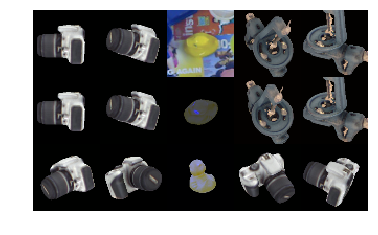

In [23]:
visualize_batch(generate_batch(5), props.DATA_PREP + "batch.png")

.  


# Task 2 Convolutional Neural Network and Loss Function

## Loss function

We define the loss function. $L=L_{triplets}+L_{pairs}$, where $L_{triplets}=\Sigma \max (0, 1-\frac{||f(x_a)-f(x_-)||^2_2}{||f(x_a)-f(x_+)||^2_2+m})$ and $L_{pairs}=\Sigma ||f(x_a)-f(x_+)||^2_2$

### _TENSORFLOW version_
Only this version can be our custom loss function used in tensorflow. The numpy version can't!

In [24]:
SESS = tf.InteractiveSession()
WRITER = tf.summary.FileWriter(props.LOGS, SESS.graph)

In [25]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var-mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        

In [26]:
def tf_loss_complete(feats): 
    #feats should be shape (batch_size * 16)
    with tf.name_scope('loss'):
        batch_size=tf.shape(feats)[0]
        #print(batch_size.eval())

        #default m
        m = 0.01

        #||f(x_a)-f(x+)|| and ||f(x_a)-f(x-)||
        diff_pos = tf.subtract(feats[0: batch_size: 3], feats[1: batch_size: 3])
        diff_neg = tf.subtract(feats[0: batch_size: 3], feats[2: batch_size: 3])

        #print(diff_pos.eval().shape)

        #||f(x_a)-f(x+)||^2 and ||f(x_a)-f(x-)||^2
        square_pos = tf.square(diff_pos)
        square_neg = tf.square(diff_neg)

        #print(square_pos.eval().shape)

        L_pairs = tf.reduce_sum(square_pos)
        tf.summary.scalar('L_pairs', L_pairs)
        
        norm_2_pos=tf.reduce_sum(square_pos, axis=1)
        norm_2_neg=tf.reduce_sum(square_neg, axis=1)

        #print(norm_2_pos.eval().shape)

        L_triplets = tf.reduce_sum(tf.maximum(0.0, tf.subtract(1.0, tf.divide(norm_2_neg, tf.add(norm_2_pos, m)))))
        tf.summary.scalar('L_triplets', L_triplets)
        
        L = tf.add(L_triplets, L_pairs)
        tf.summary.scalar('loss', L)
        return L

In [27]:
a=np.array([1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6])
test=[]
for i in range(6):
    test.append(a)
test=tf.convert_to_tensor(np.array(test), dtype=tf.float32)
print(test.shape)
print(tf_loss_complete(test).eval())

(6, 16)
2.0


## Set the network up

_The network architecture is fairly simple and closely follows that one of the famous LeNet. It consists of 2 convolutional layers, each followed by ReLu activation functions and a 2x2 max pooling layer, and 2 fully connected layers. The output descriptor size set to be 16 for all the experiments._

In [28]:
# Input Layer
#input_layer = tf.reshape(features, [-1, 64, 64, 3])
INPUT_LAYER = tf.placeholder("float32", [None, 64,64,3])
#input_layer1 = tf.reshape(input_layer, [-1, 64, 64, 3])

# Convolutional Layer #1
CONV_1 = tf.layers.conv2d(
    inputs=INPUT_LAYER,
    filters=16,
    kernel_size=[8, 8],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
POOL_1 = tf.layers.max_pooling2d(inputs=CONV_1, pool_size=[2, 2], strides=2)
   
# Convolutional Layer #2 
CONV_2 = tf.layers.conv2d(
    inputs=POOL_1,
    filters=7,
    kernel_size=[5, 5],
    padding="valid",
    activation=tf.nn.relu)
    
# Pooling Layer #2
POOL_2 = tf.layers.max_pooling2d(inputs=CONV_2, pool_size=[2, 2], strides=2)

# Flattened Layer
POOL_2_FLAT = tf.reshape(POOL_2, [-1, 12 * 12 * 7])

# First FC layer
FC_1 = tf.layers.dense(inputs=POOL_2_FLAT, units=256, activation=tf.nn.relu)

# Logits Layer
OUTPUT_LAYER = tf.layers.dense(inputs=FC_1, units = 16)

In [29]:
# Compute Loss (for both TRAIN and EVAL modes)
LOSS = tf_loss_complete(OUTPUT_LAYER)

TRAIN_OPTIMIZER = tf.train.AdamOptimizer(1e-4).minimize(LOSS)

In [30]:
SAVER = tf.train.Saver()

SESS.run(tf.global_variables_initializer())

#Notes:
#There is not a physical file called "model.ckpt". 
#It is the prefix of filenames created for the checkpoint. 
#Users only interact with the prefix instead of physical checkpoint files.

if os.path.isfile(props.WEIGHTS+'.index'):
    #We need to initiate variables to create memory for weights even we have weight to load!!
    #Sorry for not noticing that before
    SAVER.restore(SESS, props.WEIGHTS)
    print("Pretrained weight loaded")
else:
    
    print("No pretrained weight found")

No pretrained weight found


## Task 3 Evaluation and Nearest Neighbor Search

### Compute test output and evaluate it

In [31]:
def evaluate():
    # compute features on DB points and test data
    features_db = np.array([SESS.run([OUTPUT_LAYER], feed_dict={INPUT_LAYER: [image]})[0][0] for image in S_DB.images])
    features_test = np.array([SESS.run([OUTPUT_LAYER], feed_dict={INPUT_LAYER: [image]})[0][0] for image in S_TEST.images])
    
    # find nearest neighbors of features_test in features_db
    table = [[np.linalg.norm(features_test[i,:]-features_db[j,:])
              for j in range(np.shape(features_db)[0])]
            for i in range(np.shape(features_test)[0])]
    indices = np.argmin(table, axis=1) # stores index of nearest neighbor
    predicted_classes = [S_DB.classes[indices[i]] for i in range(len(indices))]
    
    # return misclassification histogram
    bins = [-1, 180, 40, 20, 10]
    histogram = [0,0,0,0,0]
    for i in range(np.shape(S_TEST.images)[0]):
        angle_diff = 360 / np.pi * np.arccos(np.abs(
            np.dot(S_TEST.quats[i], S_DB.quats[indices[i]])))
        if predicted_classes[i] == S_TEST.classes[i]:
            for t in range(len(bins[1:])):
                if angle_diff < bins[t+1]:
                    histogram[t+1] += 1
                else:
                    break
        else:
            histogram[0] += 1
    return histogram
    

In [45]:
print(evaluate())

[1853, 1682, 450, 139, 27]


## Run it

In [33]:
# Had error when
# >tensorboard
#   Fatal error in launcher: Unable to create process using '"'
# Solved with https://github.com/tensorflow/tensorflow/issues/10017
#   python -m tensorflow.tensorboard --logdir=/tmp/tboard --port=7007 &


In [34]:
SMOP = tf.summary.merge_all()
WRITER = tf.summary.FileWriter(props.LOGS)


In [35]:
# store loss every 10 iterations and histogram every 1000
LOSS_HIST = [] # loss history
HIST_HIST = [] # histograms history

In [46]:
#LOSS10=[]
for epoch in range(130):
    #TODO: load data by batch here
    batch = generate_batch(100)
    batch_images = []
    for anchor, puller, pusher in batch:
        batch_images.append(S_TRAIN.images[anchor])
        batch_images.append(S_DB.images[puller])
        batch_images.append(S_DB.images[pusher])

        
    _, summary, batchloss = SESS.run([TRAIN_OPTIMIZER, SMOP, LOSS],
                            feed_dict={INPUT_LAYER: batch_images})
    #print(summary)
    WRITER.add_summary(summary, epoch)
    if epoch % 10 == 0:
        LOSS_HIST.append(batchloss)
        if epoch % 1000 == 0:
            a = evaluate()
            HIST_HIST.append([i for i in a])
    print("Batches: ", (epoch + 1), "\tloss =", "{:.3f}".format(batchloss), end="\r", flush=True)

#save weight
SAVE_PATH = SAVER.save(SESS, props.WEIGHTS)
print("\nModel saved in path: %s" % SAVE_PATH)

Batches:  130 	loss = 6.689
Model saved in path: model/model.ckpt


In [47]:
print(HIST_HIST)

[[2782, 753, 143, 37, 5], [1863, 1672, 450, 139, 27]]


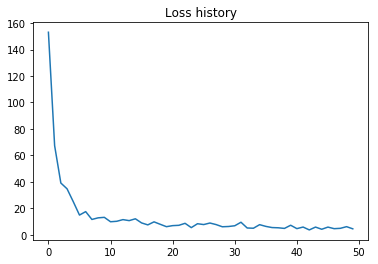

In [48]:
plt.plot(LOSS_HIST)
plt.title('Loss history')
plt.show()

Evaluation on $S_{test}$ and $S_{db}$ to get the descriptors

In [49]:
DESC_DB=[]
DESC_TEST=[]

for i in range(np.shape(S_DB.images)[0]):
    batch_images = [S_DB.images[i]]#[]
    #batch_images.append(S_TEST.images[i])

    output = SESS.run([OUTPUT_LAYER], feed_dict={INPUT_LAYER: batch_images})
    DESC_DB.append(output[0][0])
    
for i in range(np.shape(S_TEST.images)[0]):
    batch_images = [S_TEST.images[i]]
    #batch_images.append(S_TEST.images[i])

    output = SESS.run([OUTPUT_LAYER], feed_dict={INPUT_LAYER: batch_images})
    DESC_TEST.append(output[0][0])
    
DESC_DB_NP=np.array(DESC_DB)
DESC_TEST_NP=np.array(DESC_TEST)

print(DESC_DB_NP.shape)
print(DESC_TEST_NP.shape)
    

(1335, 16)
(3535, 16)


In [50]:
TABLE=np.zeros((np.shape(DESC_TEST_NP)[0],np.shape(DESC_DB_NP)[0]), dtype=np.float32)
for i in range(np.shape(DESC_TEST_NP)[0]):
    for j in range(np.shape(DESC_DB_NP)[0]):
        TABLE[i][j]=np.linalg.norm(DESC_TEST_NP[i,:]-DESC_DB_NP[j,:])
INDEXS=np.argmin(TABLE, axis=1)
RESULTS=np.zeros((len(INDEXS)), dtype=int)
for i in range(len(INDEXS)):
    RESULTS[i]=S_DB.classes[INDEXS[i]]
print(np.sum(INDEXS))
print(np.shape(RESULTS))
print(np.sum(RESULTS))
# this is correct, because the sum of results returned by the knn in opencv is the same as this one, 5011 

2362433
(3535,)
7116


In [51]:
NBANGLE10=0
NBANGLE20=0
NBANGLE40=0
NBANGLE180=0
NBERROR=0
for i in range(np.shape(S_TEST.images)[0]):
    if (RESULTS[i]==S_TEST.classes[i]):
        THETA=2 * np.arccos(np.abs(np.dot(S_TEST.quats[i], S_DB.quats[INDEXS[i]]))) / np.pi * 180
        if THETA<10:
            NBANGLE10+=1
        if THETA<20:
            NBANGLE20+=1
        if THETA<40:
            NBANGLE40+=1
        if THETA<180:
            NBANGLE180+=1
    else:
        NBERROR+=1
print(NBANGLE10, " ", NBANGLE20, " ", NBANGLE40, " ", NBANGLE180, " ",NBERROR)       

49   223   645   1940   1595


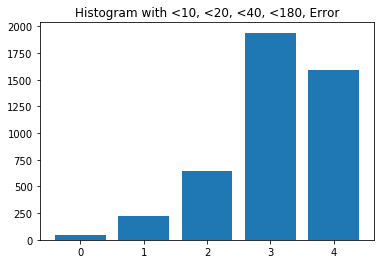

In [52]:
from __future__ import division
HIST = [NBANGLE10, NBANGLE20, NBANGLE40, NBANGLE180, NBERROR]
#plt.hist(a, bins=5, range=[0,6], normed=False)
plt.title("Histogram with <10, <20, <40, <180, Error")

plt.bar(np.arange(5), HIST)
plt.show()

In [53]:
print(HIST)

[49, 223, 645, 1940, 1595]


## New added code.

Plot in 3d

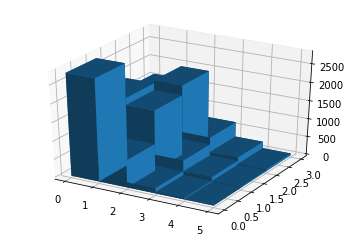

In [56]:
TOM=np.array([[2782, 753, 143, 37, 5], [1863, 1672, 450, 139, 27],[1595, 1940, 645, 233, 49]])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X_TOM, Y_TOM = np.meshgrid( np.arange(TOM.shape[1]),np.arange(TOM.shape[0]) )

X_TOM = X_TOM.flatten()
Y_TOM = Y_TOM.flatten()
Z_TOM = TOM.flatten()
ax.bar3d( X_TOM,Y_TOM,np.zeros(len(Z_TOM)),1, 1, Z_TOM )

plt.show()

To save the former plot, right click and save as...

## Bonus

Plot confusion matrix using the seaborn package

In [69]:
print(np.shape(RESULTS))
print(np.shape(S_TEST.classes))
#if (RESULTS[i]==S_TEST.classes[i]):
CONFUSION_MAT=np.zeros((5,5), dtype=np.int16)
for i in range(np.shape(RESULTS)[0]):
    CONFUSION_MAT[RESULTS[i],S_TEST.classes[i]]+=1
print(CONFUSION_MAT)

(3535,)
(3535,)
[[528   8  22  28  58]
 [ 15 373 239 227  46]
 [ 12 140 261 112  24]
 [ 29 149 141 265  66]
 [123  37  44  75 513]]


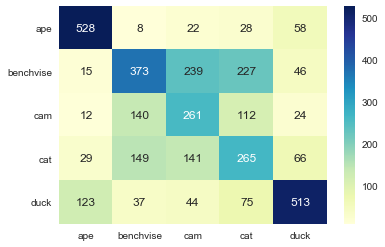

In [75]:
import seaborn as sns; sns.set()
from matplotlib import cm
import pandas as pd
DF = pd.DataFrame(CONFUSION_MAT, index=["ape","benchvise","cam","cat","duck"], columns=["ape","benchvise","cam","cat","duck"])
HEATMAP = sns.heatmap(DF, cmap=cm.YlGnBu, annot=True, fmt="d")